<h1 style="text-align:center;font-size:30px;" > QUESTION ANSWER CHAT BOT USING CORNELL MOVIE DIALOGUE CORPUS </h1>

### Intro :
At the most basic level, a chatbot is a computer program that simulates and processes human conversation (either written or spoken), allowing humans to interact with digital devices as if they were communicating with a real person.
For this assignment, we will be building a chatbot that will be trained on Cornell movie dialogue corpus that can chat like movie characters. 


### Business problem : 
By building a question answer chatbot reduces the need for human engagement significantly in cases where queries require less critical thinking and are more general. This could also save a lot of money for an organization meanwhile it can lead to more customer satisfaction since the response is spontaneous. 


### ML formulation of the business problem :
In this problem as input, we are giving a sequence of words as input and as output, we want a sequence of words. So it’s clearly a sequence to sequence mapping problem. Which we can solve either by Autoencoder architecture or Transformers.


### Performance metric:
For this sort of sequence to sequence text mapping problems most preferred metric used is 
BLEU score.




### BLEU Score : 
BLEU (bilingual evaluation understudy) is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Quality is considered to be the correspondence between a machine's output and that of a human: "the closer a machine translation is to a professional human translation, the better it is" – this is the central idea behind BLEU. BLEU was one of the first metrics to claim a high correlation with human judgements of quality and remains one of the most popular automated and inexpensive metrics.
BLEU is defined as a weighted geometric mean of n-gram precision scores, 





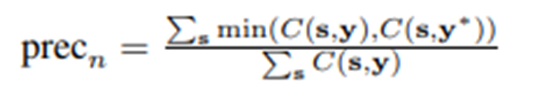

where y is the hypothesis sequence, y ∗ is the ground-truth sequence, s is an n-gram subsequence of y, and C(s, y) is the number of times s appears in y. Then BLEU is formulated as

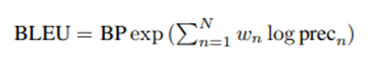

BP stands for brevity penalty, which penalizes sequences that are too short. N determines how many n-gram precision-scores to use. Finally, wn is the weight of each precision score, which often is set to 1/N.

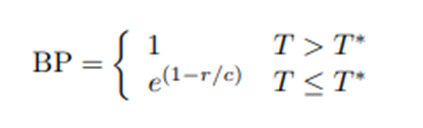

Where T is the prediction sequence length and T ∗ is the reference sequence length.

### Sources/Useful Links :

DATA SET : http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip

EXISTING SOLUTION PAPER: https://arxiv.org/abs/2006.02767

PAPER ON SEQ2SEQ ATTENTION MODEL : https://arxiv.org/abs/1409.0473

### Description of corpus:
This corpus contains a large metadata-rich collection of fictional conversations extracted from raw movie scripts:
- 220,579 conversational exchanges between 10,292 pairs of movie characters
- involves 9,035 characters from 617 movies
- in total 304,713 utterances
- movie metadata included:

    - genres
    - release year
    - IMDB rating
    - number of IMDB votes
    - IMDB rating
- character metadata included:
    - gender (for 3,774 characters)
    - position on movie credits (3,321 characters)
    
 


The above mentioned datas consists within 4 txt files-
1. movie_characters_metadata.txt
2. movie_conversations
3. movie_lines
4. movie_titles_metadata


In [9]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import re
from tqdm import tqdm
import pickle

## Loading these files into data frames and Basic EDA

### Loading movie_conversations.txt file

In [1]:

path = "E:\Applied_AI\Case_Studies\Case Study 2\cornell movie-dialogs corpus\movie_conversations.txt"

with open(path, 'r', encoding="utf8") as f:
    u1=[]
    u2=[]
    movie = []
    lines = []

    for i in f.readlines():
        sp = i.split(" +++$+++ ")
        u1.append(sp[0])
        u2.append(sp[1])
        movie.append(sp[2])
        k = sp[3].strip('\n')[1:-1].replace("'","").replace(" ","")
        lines.append(k.split(','))

        '''lin =[]
        
        for j in k:
          if j.isalnum():
            s = s + j

          elif s != '': 
            lin.append(s)
            s = ''
        lines.append(lin)'''

    f.close()
# creating data frame for with italian and english words

movie_conversations = pd.DataFrame(data = list(zip(u1,u2,movie,lines)), columns = ['u1','u2','movie','lines'])
print(movie_conversations.shape)

movie_conversations.head()

(83097, 4)


,u1,u2,movie,lines
0,u0,u2,m0,"[L194, L195, L196, L197]"
1,u0,u2,m0,"[L198, L199]"
2,u0,u2,m0,"[L200, L201, L202, L203]"
3,u0,u2,m0,"[L204, L205, L206]"
4,u0,u2,m0,"[L207, L208]"


#### About the above table:
    u1 ---> First actor id in the conversation
    u2 ---> Seconf actor id in the conversation
    movie ---> movie id
    lines ---> line ids for a conversation

In [2]:
# Checking if any null value is there
movie_conversations.isnull().sum()

u1       0
u2       0
movie    0
lines    0
dtype: int64

In [3]:
print(" Number of Unique Movies :", len(movie_conversations.movie.unique()))

 Number of Unique Movies : 617


In [4]:
movie_conversations['lines_per_con'] = [len(i) for i in movie_conversations.lines]

# To get Total Number of conversation lines each movie have
movie_con_count = movie_conversations.groupby(by ='movie').agg({'lines_per_con' : sum}).reset_index()

In [5]:
#Getting percenile values of total conversation lines per conversation
for x in np.arange(10,110,10):
    print(f"{x} percentile converstion lines per conversation {np.percentile(movie_conversations['lines_per_con'], x)}")

10 percentile converstion lines per conversation 2.0
20 percentile converstion lines per conversation 2.0
30 percentile converstion lines per conversation 2.0
40 percentile converstion lines per conversation 2.0
50 percentile converstion lines per conversation 3.0
60 percentile converstion lines per conversation 3.0
70 percentile converstion lines per conversation 4.0
80 percentile converstion lines per conversation 5.0
90 percentile converstion lines per conversation 7.0
100 percentile converstion lines per conversation 89.0


In [6]:
#Getting percenile values of total conversation lines per movie
for x in np.arange(10,110,10):
    print(f"{x} percentile converstion lengths per movie {np.percentile(movie_con_count ['lines_per_con'], x)}")

10 percentile converstion lengths per movie 236.0
20 percentile converstion lengths per movie 303.0
30 percentile converstion lengths per movie 357.79999999999995
40 percentile converstion lengths per movie 418.8
50 percentile converstion lengths per movie 474.0
60 percentile converstion lengths per movie 525.5999999999999
70 percentile converstion lengths per movie 591.2
80 percentile converstion lengths per movie 665.8
90 percentile converstion lengths per movie 777.8
100 percentile converstion lengths per movie 1530.0


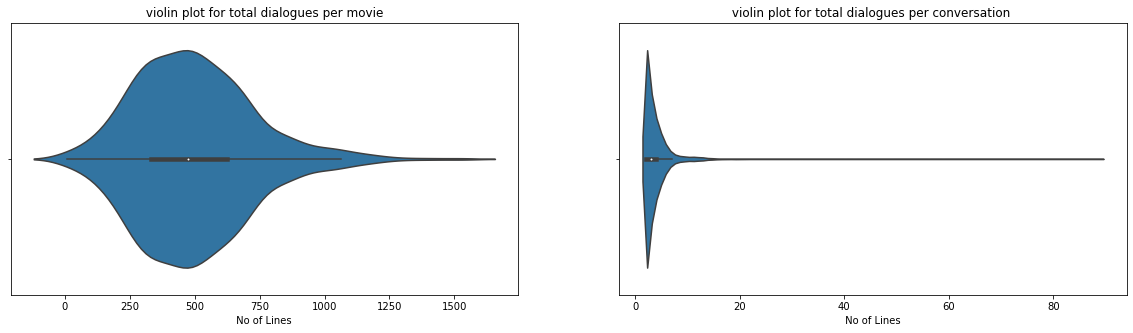

In [23]:
#Plotting for feture_1
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.violinplot(movie_con_count ['lines_per_con'])
plt.xlabel(" No of Lines ")

plt.title(" violin plot for total dialogues per movie ")
plt.subplot(1,2,2)
sns.violinplot(movie_conversations['lines_per_con'])
plt.title(" violin plot for total dialogues per conversation  ")
plt.xlabel(" No of Lines ")
plt.show()

### Loading movie_lines.txt file

In [14]:
path = "E:\Applied_AI\Case_Studies\Case Study 2\cornell movie-dialogs corpus\movie_lines.txt"

with open(path, 'r', encoding="utf8",  errors='ignore') as f:

    line_no = []
    u1 = []
    movie = []
    u1_name = []
    dialogue = []

    for i in f.readlines():
        sp = i.split(" +++$+++ ")
        line_no.append(sp[0])
        u1.append(sp[1])
        movie.append(sp[2])
        u1_name.append(sp[3])
        dialogue.append(sp[4].strip('\n'))
        
    f.close()
# creating data frame for with italian and english words


movie_lines = pd.DataFrame(data = list(zip(line_no, u1, movie, u1_name, dialogue)), columns = ['line_no','u1','movie','u1_name', 'dialogue'])
print(movie_lines.shape)

movie_lines.head()

(304713, 5)


,line_no,u1,movie,u1_name,dialogue
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


#### About the above table:
    line_no ---> Line id of a dialogue
    u1 ---> Actor id, who is delivering the dialogue
    u1_name ---> charector name 
    dialogue ---> line dialogue

In [38]:
# Checking if any null value is there
movie_lines.isnull().sum()

line_no     0
u1          0
movie       0
u1_name     0
dialogue    0
dtype: int64

In [53]:
print("Total no of unique charecters :",len(movie_lines.u1.unique()))

Total no of unique charecters : 9035


In [32]:
#To get number of unique Charecters per movie
m_uniq_char = movie_lines.groupby(['movie']).agg({'u1' : 'nunique'}).reset_index()
m_uniq_char.columns = ['movie', 'unique_chars']

In [34]:
#Getting percenile values of unique charectrs per movie
for x in np.arange(10,110,10):
    print(f"{x} percentile converstion lengths per movie {np.percentile(m_uniq_char['unique_chars'], x)}")

10 percentile converstion lengths per movie 8.0
20 percentile converstion lengths per movie 10.0
30 percentile converstion lengths per movie 12.0
40 percentile converstion lengths per movie 13.0
50 percentile converstion lengths per movie 14.0
60 percentile converstion lengths per movie 15.0
70 percentile converstion lengths per movie 17.0
80 percentile converstion lengths per movie 19.0
90 percentile converstion lengths per movie 22.0
100 percentile converstion lengths per movie 44.0


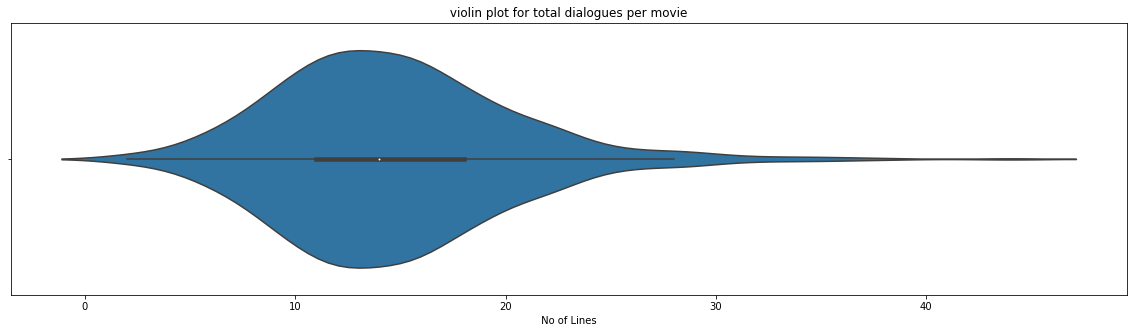

In [37]:
#Plotting for feture_1
plt.figure(figsize=(20,5))

sns.violinplot(m_uniq_char['unique_chars'])
plt.xlabel(" No of Lines ")

plt.title(" violin plot for total dialogues per movie ")
plt.show()

### Loading movie_characters_metadata.txt file

In [50]:
path = "E:\Applied_AI\Case_Studies\Case Study 2\cornell movie-dialogs corpus\movie_characters_metadata.txt"

with open(path, 'r', encoding="utf8",  errors='ignore') as f:

    
    u1 = []
    u_name = []
    movie = []
    title = []
    gender = []
    rank_in_movie = []

    for i in f.readlines():
        sp = i.split(" +++$+++ ")
        u1.append(sp[0])
        u_name.append(sp[1])
        movie.append(sp[2])
        title.append(sp[3])
        gender.append(sp[4])
        rank_in_movie.append(sp[5].strip('\n'))
        
    f.close()
# creating data frame for with italian and english words


characters_metadata = pd.DataFrame(data = list(zip(u1, u_name, movie, title, gender, rank_in_movie)), columns = ['u1','u_name','movie','title', 'gender','rank_in_movie'])
print(characters_metadata.shape)

characters_metadata.head()

(9035, 6)


,u1,u_name,movie,title,gender,rank_in_movie
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


#### About the above table:
    u1 ---> Actor id, who is delivering the dialogue
    u_name ---> charector name
    title ---> movie title
    movie ---> movie id
    gender ---> charecter's gender
    rank_in_movie ---> Charets ranking in the movie credits

In [42]:
movie_ = movie_lines.merge(characters_metadata[['u1','gender']], on = 'u1', how = 'left'  )

In [43]:
def get_gender(x):
    if x.isalnum():
        return x.lower()
    else: return 'gender'
    

In [46]:
# imputting unknown genders with gender string
movie_.gender = movie_.gender.apply(get_gender)

In [47]:
movie_.gender.value_counts()

m         170768
f          71255
gender     62690
Name: gender, dtype: int64

In [106]:
movie_

,line_no,u1,movie,u1_name,dialogue,gender
0,L1045,u0,m0,BIANCA,They do not!,f
1,L1044,u2,m0,CAMERON,They do to!,m
2,L985,u0,m0,BIANCA,I hope so.,f
3,L984,u2,m0,CAMERON,She okay?,m
4,L925,u0,m0,BIANCA,Let's go.,f
...,...,...,...,...,...,...
304708,L666371,u9030,m616,DURNFORD,Lord Chelmsford seems to want me to stay back ...,gender
304709,L666370,u9034,m616,VEREKER,I'm to take the Sikali with the main column to...,gender
304710,L666369,u9030,m616,DURNFORD,"Your orders, Mr Vereker?",gender
304711,L666257,u9030,m616,DURNFORD,"Good ones, yes, Mr Vereker. Gentlemen who can ...",gender


### Loading movie_titles_metadata.txt file

In [59]:
path = "E:\Applied_AI\Case_Studies\Case Study 2\cornell movie-dialogs corpus\movie_titles_metadata.txt"

with open(path, 'r', encoding="utf8",  errors='ignore') as f:

    

    movie = []
    title = []
    year = []
    movie_ranking = []
    movie_votes = []
    genre = []

    for i in f.readlines():
        sp = i.split(" +++$+++ ")
        movie.append(sp[0])
        title.append(sp[1])
        year.append(sp[2])
        movie_ranking.append(sp[3])
        movie_votes.append(sp[4])
        k = sp[5].strip('\n')[1:-1].replace("'","").replace(" ","")
        genre.append(k.split(','))
        
        
    f.close()
# creating data frame for with italian and english words


titles_metadata = pd.DataFrame(data = list(zip(movie, title, year, movie_ranking, movie_votes, genre)), columns = ['movie', 'title', 'year', 'movie_ranking', 'movie_votes', 'genre'])
print(titles_metadata.shape)

titles_metadata.head()

(617, 6)


,movie,title,year,movie_ranking,movie_votes,genre
0,m0,10 things i hate about you,1999,6.90,62847,"[comedy, romance]"
1,m1,1492: conquest of paradise,1992,6.20,10421,"[adventure, biography, drama, history]"
2,m2,15 minutes,2001,6.10,25854,"[action, crime, drama, thriller]"
3,m3,2001: a space odyssey,1968,8.40,163227,"[adventure, mystery, sci-fi]"
4,m4,48 hrs.,1982,6.90,22289,"[action, comedy, crime, drama, thriller]"


#### About the above table:
    movie ---> movie id
    title---> movie title
    year ---> movie release year
    movie_ranking ---> IMDB movie ranking
    movie_votes ---> IMDB voting
    genre ---> Movie genre
    


In [72]:
titles_metadata.loc[110:119]

,movie,title,year,movie_ranking,movie_votes,genre
110,m110,kalifornia,1993,6.70,21830,"[crime, drama, thriller]"
111,m111,kids,1995,6.80,26546,"[crime, drama]"
112,m112,knight moves,1992,5.80,3272,"[mystery, thriller]"
113,m113,krull,1983,5.90,8246,"[fantasy, action, adventure, sci-fi]"
114,m114,lon,1994,8.60,204901,"[crime, drama, thriller]"
115,m115,labor of love,1998,4.50,45,[]
116,m116,leaving las vegas,1995,7.60,42919,"[drama, romance]"
117,m117,legally blonde,2001,6.20,44558,[comedy]
118,m118,legend,1985,6.20,20907,"[fantasy, adventure, romance]"
119,m119,life as a house,2001,7.50,19468,"[drama, romance]"


In [93]:
# To get total no of genres
genre_class = []

for i in titles_metadata.genre:
    
    genre_class += i 
genres = set(genre_class)

genre_cnt = {}
cnt = 0
for i in genres:
    for j in titles_metadata.genre:
        if i in j:
            cnt += 1
    genre_cnt[i] = cnt
    
genre_cnt

{'': 1,
 'crime': 146,
 'comedy': 305,
 'history': 326,
 'musical': 334,
 'music': 347,
 'drama': 667,
 'thriller': 932,
 'sport': 940,
 'war': 963,
 'adventure': 1070,
 'biography': 1095,
 'horror': 1193,
 'action': 1351,
 'fantasy': 1425,
 'adult': 1426,
 'romance': 1558,
 'sci-fi': 1670,
 'short': 1675,
 'documentary': 1678,
 'western': 1690,
 'mystery': 1790,
 'film-noir': 1794,
 'family': 1810,
 'animation': 1826}

In [94]:
# To find null genre
[i for i in range(617) if "" in titles_metadata.genre[i]]

[115]

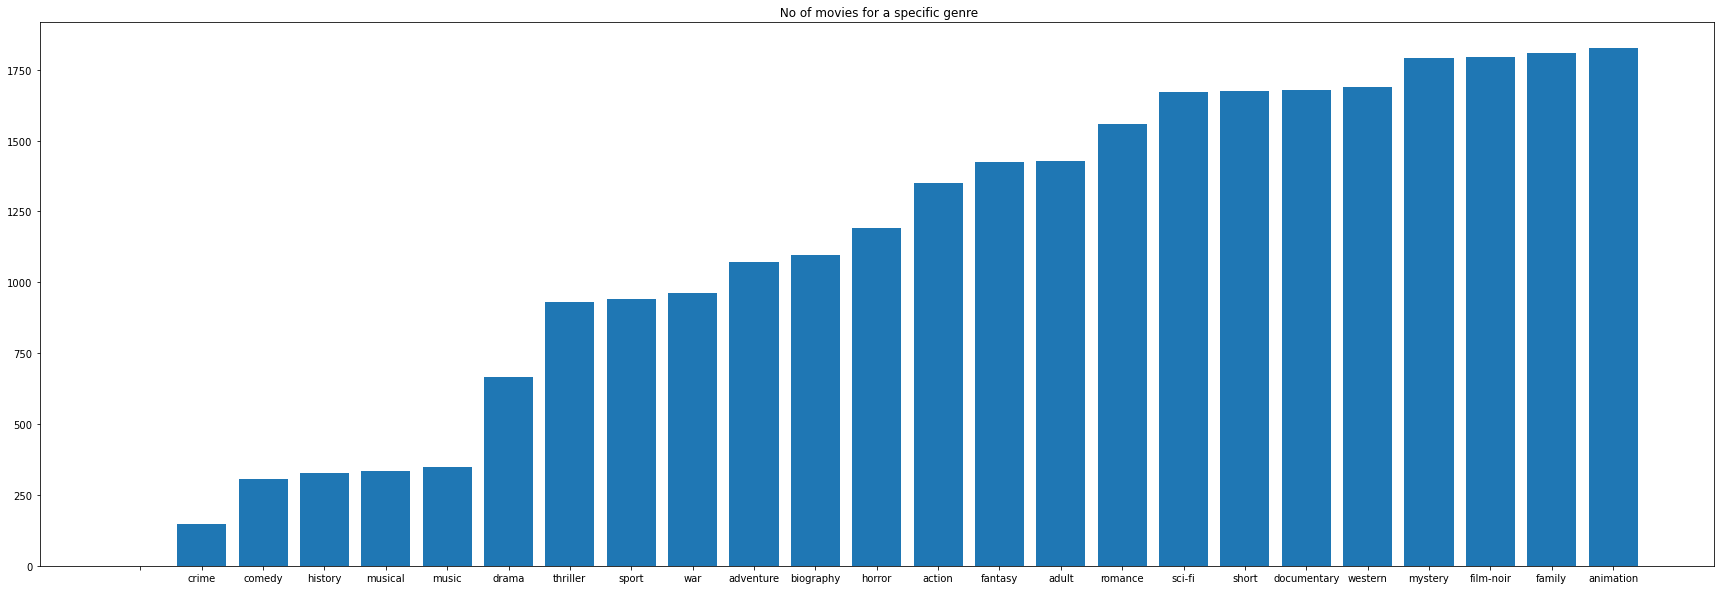

In [99]:
plt.figure(figsize= (30,10))
plt.title(" No of movies for a specific genre")
plt.bar(genre_cnt.keys(),genre_cnt.values())
plt.show()

In [100]:
l = [len(i) for i in titles_metadata.genre]

#Getting percenile values of numver of genres per movie

for x in np.arange(10,110,10):
    print(f"{x} percentile converstion lengths per movie {np.percentile(l, x)}")

10 percentile converstion lengths per movie 1.0
20 percentile converstion lengths per movie 2.0
30 percentile converstion lengths per movie 2.0
40 percentile converstion lengths per movie 3.0
50 percentile converstion lengths per movie 3.0
60 percentile converstion lengths per movie 3.0
70 percentile converstion lengths per movie 4.0
80 percentile converstion lengths per movie 4.0
90 percentile converstion lengths per movie 4.399999999999977
100 percentile converstion lengths per movie 11.0


In [101]:
#Getting percenile values of numver of genres per movie
for x in np.arange(90,101,1):
    print(f"{x} percentile converstion lengths per movie {np.percentile(l, x)}")

90 percentile converstion lengths per movie 4.399999999999977
91 percentile converstion lengths per movie 5.0
92 percentile converstion lengths per movie 5.0
93 percentile converstion lengths per movie 5.0
94 percentile converstion lengths per movie 5.0
95 percentile converstion lengths per movie 5.0
96 percentile converstion lengths per movie 5.0
97 percentile converstion lengths per movie 5.0
98 percentile converstion lengths per movie 6.67999999999995
99 percentile converstion lengths per movie 8.0
100 percentile converstion lengths per movie 11.0


## Preprocessing and getting the structured data

For first model I'm just working with the dialougues for any given conversation. I'm considering the first line of a conversation as encoder input and the second line as the reply, So it should be output that we need.

In [109]:
dic_line = {k : v for k, v in zip(movie_lines.line_no,movie_lines.dialogue)}
#dic_line

In [108]:
#dic_line_gender = {k : v for k, v in zip(movie_.line_no,movie_.gender)}
#dic_line_gender

In [105]:
# Sort the sentences into questions (inputs) and answers (targets)
encoder_inp = []
encoder_gender = []
decoder_inp = []
decoder_gender = [ ]
for lines in movie_conversations.lines:
    for i in range(len(lines)-1):
        encoder_inp.append(dic_line[lines[i]])
        decoder_inp.append(dic_line[lines[i+1]])

In [113]:
data = pd.DataFrame(zip(encoder_inp,decoder_inp), columns=['enc_inp','dec_inp'])

In [114]:
data

,enc_inp,dec_inp
0,Can we make this quick? Roxanne Korrine and A...,"Well, I thought we'd start with pronunciation,..."
1,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....
2,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...
3,You're asking me out. That's so cute. What's ...,Forget it.
4,"No, no, it's my fault -- we didn't have a prop...",Cameron.
...,...,...
221611,"Your orders, Mr Vereker?",I'm to take the Sikali with the main column to...
221612,I'm to take the Sikali with the main column to...,Lord Chelmsford seems to want me to stay back ...
221613,Lord Chelmsford seems to want me to stay back ...,I think Chelmsford wants a good man on the bor...
221614,"Well I assure you, Sir, I have no desire to cr...","And I assure you, you do not In fact I'd be ob..."


In [112]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text



In [115]:
#Preprocessing the Data dataframe
data['enc_inp'] = data['enc_inp'].apply(preprocess)
data['dec_inp'] = data['dec_inp'].apply(preprocess)
data.head()

,enc_inp,dec_inp
0,can we make this quick roxanne korrine and an...,well i thought we would start with pronunciati...
1,well i thought we would start with pronunciati...,not the hacking and gagging and spitting part ...
2,not the hacking and gagging and spitting part ...,okay then how bout we try out some french cuis...
3,you are asking me out that is so cute what is...,forget it
4,no no it is my fault we did not have a proper...,cameron


In [124]:
enc_inp_len = data['enc_inp'].str.split().apply(len)
dec_inp_len = data['dec_inp'].str.split().apply(len)

#99 percentile of english and italian sentences length

print('95 percentile of encoder input and decoder input sentences length %d and %d'%(np.percentile(enc_inp_len,95),np.percentile(dec_inp_len,95)))

95 percentile of encoder input and decoder input sentences length 32 and 33


In [125]:
data['enc_inp_len'] = data['enc_inp'].str.split().apply(len)
data = data.loc[data['enc_inp_len'] <= 32]

data['dec_inp_len'] = data['dec_inp'].str.split().apply(len)
data = data.loc[data['dec_inp_len'] <= 33]

#Adding <start> in start of english input and <end> at the end of each english output

data['dec_input'] = '<start> ' + data['dec_inp'].astype(str)
data['dec_output'] = data['dec_inp'].astype(str) + ' <end>'

data = data.drop(['dec_inp','dec_inp_len','enc_inp_len'], axis=1)
data.head()

,enc_inp,dec_input,dec_output
0,can we make this quick roxanne korrine and an...,<start> well i thought we would start with pro...,well i thought we would start with pronunciati...
1,well i thought we would start with pronunciati...,<start> not the hacking and gagging and spitti...,not the hacking and gagging and spitting part ...
2,not the hacking and gagging and spitting part ...,<start> okay then how bout we try out some fre...,okay then how bout we try out some french cuis...
3,you are asking me out that is so cute what is...,<start> forget it,forget it <end>
4,no no it is my fault we did not have a proper...,<start> cameron,cameron <end>


In [126]:
#Splitting data into train and validation 
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [127]:
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['dec_input']= str(train.iloc[0]['dec_input'])+' <end>'
train.iloc[0]['dec_output']= str(train.iloc[0]['dec_output'])+' <end>'

In [128]:
train.head()

,enc_inp,dec_input,dec_output
12474,i think it is important not to get depressed d...,<start> aunt barbara i will try not to get dep...,aunt barbara i will try not to get depressed <...
68700,i missed you i wondered if you were ever comi...,<start> me too,me too <end>
30793,give me that i am going to throw it in the se...,<start> she took my head,she took my head <end>
61573,bud,<start> sorry i had to help my folks and then...,sorry i had to help my folks and then i could...
103682,you killed him did not you,<start> i knew you were thinking that i could...,i knew you were thinking that i could see it ...


In [129]:
validation.head()

,enc_inp,dec_input,dec_output
104680,no it is not your fault the walls here are ju...,<start> are they really,are they really <end>
147523,yes sir,<start> anyway any particular reason you did n...,anyway any particular reason you did not give ...
114693,why you wanna have sex or something,<start> ooh can we,ooh can we <end>
20922,what do you mean better in bed you either do i...,<start> no there are variables that like i mig...,no there are variables that like i might not b...
76821,no c amon i am listening i was just,<start> just what,just what <end>


In [130]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [131]:
tknizer_enc = Tokenizer()
tknizer_enc.fit_on_texts(train['enc_inp'].values)

tknizer_dec = Tokenizer(filters = "")
tknizer_dec.fit_on_texts(train['dec_input'].values)

In [133]:
vocab_size_dec=len(tknizer_dec.word_index.keys())
print("Decoder vocab size : ",vocab_size_dec)

vocab_size_enc =len(tknizer_enc.word_index.keys())
print("Encoder vocab size : ",vocab_size_enc)

Decoder vocab size :  40546
Encoder vocab size :  40022


In [134]:
tknizer_dec.word_index['<start>'], tknizer_dec.word_index['<end>']

(1, 20733)

In [135]:
#Converting all the texts into arrays of tokens

from tensorflow.keras.preprocessing.sequence import pad_sequences

train_enc = tknizer_enc.texts_to_sequences(train.enc_inp)
train_dec_input = tknizer_dec.texts_to_sequences(train.dec_input)
train_dec_output = tknizer_dec.texts_to_sequences(train.dec_output)

validation_enc = tknizer_enc.texts_to_sequences(train.enc_inp)
validation_dec_input = tknizer_dec.texts_to_sequences(train.dec_input)
validation_dec_output = tknizer_dec.texts_to_sequences(train.dec_output)

In [136]:
#Adding padding after tokenization since all the input data should have equal length

train_enc = pad_sequences(train_enc,maxlen = 32, padding='post')
train_dec_input = pad_sequences(train_dec_input,maxlen = 33, padding='post')
train_dec_output = pad_sequences(train_dec_output,maxlen = 33, padding='post')

validation_enc = pad_sequences(validation_enc,maxlen = 32, padding='post')
validation_dec_input = pad_sequences(validation_dec_input,maxlen = 33, padding='post')
validation_dec_output = pad_sequences(validation_dec_output,maxlen = 33, padding='post')

In [137]:
#Getting the training data sets for models
x_tr,y_tr = [train_enc,train_dec_input],train_dec_output

In [141]:
y_tr.shape

(160402, 33)

In [142]:
x_tr[0].shape

(160402, 32)

In [143]:
x_tr[1].shape

(160402, 33)